In [1]:
using Evolutionary
using Flux
using Flux: onehot, onecold, logitcrossentropy, onehotbatch, crossentropy
using MLDatasets
using Random
using Statistics
using MLJBase
using Printf
using BSON: @load # for load weights
using Plots
using DelimitedFiles
import Evolutionary.initial_population
using Zygote
import Evolutionary.NonDifferentiable
import Base: copy, copyto!

In [2]:
Random.seed!(63456345)

TaskLocalRNG()

In [3]:
rawdata = readdlm("data/test2.csv",',',skipstart=1)';
one = 0
zero = 0
for i in rawdata[20,:]
if i == 1
    one = one + 1
else
    zero = zero + 1
end
end
difference = one - zero
function newrand()
    randCol = zeros(0)
    push!(randCol, rand(10.0:99.0))
    push!(randCol, rand(5.3:40.2))
    push!(randCol, rand(1.1:15.1))
    push!(randCol, rand(0.1:8.1))
    push!(randCol, rand(1.1:15.1))
    push!(randCol, rand(30.1:60.1))
    push!(randCol, rand(0.1:0.9))
    push!(randCol, rand(0.1:4.1))
    push!(randCol, rand(20.1:50.1))
    push!(randCol, rand(0.1:5.1))
    push!(randCol, rand(0.1:7.1))
    push!(randCol, rand(45.1:99.1))
    push!(randCol, rand(0.1:5.1))
    push!(randCol, rand(0.1:5.1))
    push!(randCol, rand(0.1:7.1))
    push!(randCol, rand(0.1:7.1))
    push!(randCol, rand(0.1:3.1))
    push!(randCol, rand(0.1:3.1))
    push!(randCol, rand(0.1:5.1))
    if rand(0:1) == 0
        push!(randCol, 0.0)
    else
        push!(randCol, 1.0)
    end
    return randCol
end
for i = 1:size(rawdata,2)
    if rawdata[20,i] == 0 && difference > 0
        rawdata = hcat(rawdata, rawdata[:,i])
        rawdata = hcat(rawdata, newrand())
        difference = difference - 1
    end
end
filldata = rawdata[ :, shuffle(1:end)];
x = filldata[1:19, :]
y = filldata[20, :];
x_train = x[:,1:floor(Int, size(x,2)*0.7)]
y_train = y[1:floor(Int, size(x,2)*0.7)]
x_test = x[:,floor(Int, size(x,2)*0.7)+1:end]
y_test = y[floor(Int, size(x,2)*0.7)+1:end];

In [4]:
train_data = [ (x, onehot(l, unique(y_train))) for (x, l) in zip(eachcol(x_train), y_train)]
test_data = [ (x, onehot(l, unique(y_test))) for (x, l) in zip(eachcol(x_test), y_test)];

In [5]:
accuracy(xy, model) = mean( onecold(model(x)) .== onecold(y) for (x,y) in xy)
loss(model) = (x,y)->logitcrossentropy(model(x), y)
loss(model,x,y) = loss(model)(x, y)
loss(xy, model) = loss(model)(hcat(map(first,xy)...), hcat(map(last,xy)...))

loss (generic function with 3 methods)

In [6]:
fitness(m) = loss(train_data, m)

fitness (generic function with 1 method)

In [7]:
function initial_population(method::M, individual::Chain) where {M<:Evolutionary.AbstractOptimizer}
    θ, re = Flux.destructure(individual);
    [re(randn(length(θ))) for i in 1:Evolutionary.population_size(method)]
    end

initial_population (generic function with 6 methods)

In [8]:
NonDifferentiable(f, x::Chain) = NonDifferentiable{Real,typeof(x)}(f, f(x), deepcopy(x),[0,])
copy(ch::Chain) = deepcopy(ch)
# copy weight and bias between two models
function copyto!(layer1::Dense{T}, layer2::Dense{T}) where {T}
    copyto!(layer1.W, layer2.W)
    copyto!(layer1.b, layer2.b)
    return l1
end
function copyto!(ch1::Chain, ch2::Chain)
    for i in 1:length(ch1.layers)
        copyto!(ch1.layers[i],ch2.layers[i])
    end
    return ch1
end

copyto! (generic function with 140 methods)

In [9]:
#model = Chain(Dense(19, 2*19, sigmoid), Dense(2*19, 2))

In [10]:
#methods(ES)

In [11]:
# # the iterations is performed later
# opts = Evolutionary.Options(iterations=10,successive_f_tol= 10)
# algo = ES(
#     selection = :comma,
#     mu = 10,
#     lambda = 70,
# )

In [12]:
# opts = Evolutionary.Options(iterations=1)

# algo = ES(
#     initStrategy=IsotropicStrategy(3), 
#     μ=10, 
#     ρ=3, 
#     λ=100, 
#     selection=:plus)

In [13]:
# epochs = 500 # the number of epochs
# # change population_size will increase training time, but may increase the accuracy
# save_resultTest = zeros(epochs);
# save_resultTrain = zeros(epochs);
# # l1 = Dense(19, 2*19, sigmoid)
# # l2 = Dense(2*19, 2)
# model = Chain(Dense(19, 2*19, sigmoid), Dense(2*19, 2))#define the model 


In [14]:
# for i in 1:10
    
#     # load the models saved from HW1
#     loadpath = string("models/model",i,".bson")
#     @load loadpath weights
#     Flux.loadparams!(model, weights)

#     res = Evolutionary.optimize(fitness, model, algo, opts)
#     evomodel = Evolutionary.minimizer(res)

#     for j in 1:epochs
#         res = Evolutionary.optimize(fitness, model, algo, opts)
#         model= Evolutionary.minimizer(res)
#         if j%(epochs/5) == 0
#         @printf("Loss in expirment %d epoch: %d in test data is %f\n",i, j, loss(test_data,model))
#         end
#         save_resultTest[j] = save_resultTest[j] + accuracy(test_data, model)
#         save_resultTrain[j] = save_resultTrain[j] + accuracy(train_data, model)
#     end
# end


In [15]:
# save_resultTest = save_resultTest ./ 10;
# save_resultTrain = save_resultTrain ./ 10;

# plot(log.(1:epochs), save_resultTest,label="Test")
# plot!(log.(1:epochs), save_resultTrain,label = "Train", title = "Accuracy", legend = :outertopleft)


In [16]:
opts = Evolutionary.Options(iterations=1,successive_f_tol= 2)
algo = ES(
    μ=50, 
    λ=3*50, 
    selection=:plus)


ES(NoStrategy(), first, first, Evolutionary.var"#42#45"(), identity, 50, 50, 350, :comma)

In [17]:
epochs = 600 # the number of epochs
# change population_size will increase training time, but may increase the accuracy
save_resultTest = zeros(epochs);
save_resultTrain = zeros(epochs);
# l1 = Dense(19, 2*19, sigmoid)
# l2 = Dense(2*19, 2)
model = Chain(Dense(19, 2*19, sigmoid), Dense(2*19, 2))#define the model 

Chain(
  Dense(19, 38, σ),                     # 760 parameters
  Dense(38, 2),                         # 78 parameters
)                   # Total: 4 arrays, 838 parameters, 3.523 KiB.

In [28]:
loadpath = string("newmodel/model",8166,".bson")

@load loadpath model

In [29]:
accuracy(test_data, model)

0.7365771812080537

In [30]:
accuracy(train_data, model)

0.29250720461095103

In [19]:

    
    # load the models saved from HW1
    # loadpath = string("models/model",1,".bson")
    # @load loadpath weights
    # Flux.loadparams!(model, weights)

    res = Evolutionary.optimize(fitness, model, algo, opts)
    evomodel = Evolutionary.minimizer(res)

    for j in 1:epochs
        res = Evolutionary.optimize(fitness, model, algo, opts)
        model= Evolutionary.minimizer(res)
        # if j%(epochs/5) == 0
        # @printf("Loss in expirment %d epoch: %d in test data is %f\n",i, j, loss(test_data,model))
        # end
        save_resultTest[j] = save_resultTest[j] + accuracy(test_data, model)
        save_resultTrain[j] = save_resultTrain[j] + accuracy(train_data, model)
    end



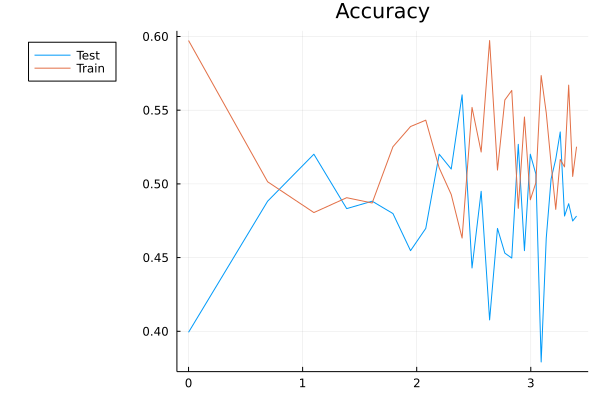

In [20]:
save_resultTest = save_resultTest ./ 1;
save_resultTrain = save_resultTrain ./ 1;

plot(log.(1:epochs), save_resultTest,label="Test")
plot!(log.(1:epochs), save_resultTrain,label = "Train", title = "Accuracy", legend = :outertopleft)

In [26]:
simplified_x_train_result = []
for i  = 1:size(x_train,2)
    if softmax(model(x_train[:,i]))[1]>0.5
        push!(simplified_x_train_result, 0)
    else
        push!(simplified_x_train_result, 1)
    end
end
simplified_y_train = []
for i  = 1:size(x_train,2)
    if y_train[i] == 0
        push!(simplified_y_train, 0)
    else
        push!(simplified_y_train, 1)
    end
end

# ConfusionMatrix for the training data
print("ConfusionMatrix for the training data\n")
ConfusionMatrix()(simplified_x_train_result, simplified_y_train)


ConfusionMatrix for the training data


┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\xkzmx\.julia\packages\MLJBase\pCiRR\src\measures\confusion_matrix.jl:112


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      0      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │     514     │     275     │
├─────────────┼─────────────┼─────────────┤
│      1      │     175     │     424     │
└─────────────┴─────────────┴─────────────┘


In [27]:
simplified_x_test_result = []
for i  = 1:size(x_test,2) 
    if softmax(model(x_test[:,i]))[1]>0.5
        push!(simplified_x_test_result, 0)
    else
        push!(simplified_x_test_result, 1)
    end
end
simplified_y_test = []
for i  = 1:size(x_test,2) 
    if y_test[i] == 0
        push!(simplified_y_test, 0)
    else
        push!(simplified_y_test, 1)
    end
end

# ConfusionMatrix for the test data
print("ConfusionMatrix for the test data\n")
ConfusionMatrix()(simplified_x_test_result, simplified_y_test)

ConfusionMatrix for the test data


┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\xkzmx\.julia\packages\MLJBase\pCiRR\src\measures\confusion_matrix.jl:112


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      0      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │     224     │     104     │
├─────────────┼─────────────┼─────────────┤
│      1      │     82      │     186     │
└─────────────┴─────────────┴─────────────┘
